<strong>Your assignment is to perform the following steps and explain your approach and result in the form of a Jupyter notebook.</strong>

* Explore the available data using the data exploration tools covered in class. Show your analysis in the form of tabular reports, graphs, and commentary.
* Use the exploration results to choose and/or craft features to use in a model. Explain why you chose each feature and then show how you modified and/or crafted the features.
* Choose and apply <strong>at least two</strong> appropriate machine learning (ML) models to predict whether a patient is at risk of developing serious illness based on their medical history. Show all your code and results. The two models can be of a different types or the same type but with different features. At least one of the models must have a hyper parameter.
* Assess the models' performance. Use all the tools we discussed in class in your assessment including the various metrics associated with the confusion matrix and an analysis of ROC . Compute the metrics and explain their value in comparing the models' performance.

IMPORT PACKAGES & READ IN CSV

In [57]:
# import packages
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [58]:
df = pd.read_csv("Covid Data.csv")
print(df.shape)
df.head()

(1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


FIRST LOOK

In [59]:
# data types look good. I do not plan on using the DATE_DIED column for analysis or
# model building so it's fine to leave as is
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [60]:
# seems like there are no missing values besides the known 97, 98, 99 value placeholders (according to data card)
df.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

DATA CLEANING

In [61]:
# First thing to do is create our label. I wanted to use patient death as the variable to predict,
# but for that we would first have to create a new column using the DATE_DIED column in the dataset.

df['DEATH'] = [2 if row=='9999-99-99' else 1 for row in df['DATE_DIED']]
print(df['DEATH'].value_counts())

# Drop the DATE_DIED column since we no longer need it
df.drop('DATE_DIED', axis=1, inplace=True)

df.head()

DEATH
2    971633
1     76942
Name: count, dtype: int64


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,1
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,1
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,1
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,1
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,1


In [62]:
# Now it's time to deal with the missing values. First I want to see what the total counts
# of missing values are in each column

missing_vals = {}

for col in df.columns:
    missing_vals[col] = df.loc[(df[col] == 97) | (df[col] == 98) | (df[col] == 99), col].count()

print(missing_vals)

{'USMER': 0, 'MEDICAL_UNIT': 0, 'SEX': 0, 'PATIENT_TYPE': 0, 'INTUBED': 855869, 'PNEUMONIA': 16003, 'AGE': 345, 'PREGNANT': 527265, 'DIABETES': 3338, 'COPD': 3003, 'ASTHMA': 2979, 'INMSUPR': 3404, 'HIPERTENSION': 3104, 'OTHER_DISEASE': 5045, 'CARDIOVASCULAR': 3076, 'OBESITY': 3032, 'RENAL_CHRONIC': 3006, 'TOBACCO': 3220, 'CLASIFFICATION_FINAL': 0, 'ICU': 856032, 'DEATH': 0}


Based on the values in the dictionary:


Columns to drop: (too many missing values to keep)
* INTUBED
* ICU
* PREGNANT


Rows to drop: (few enough missing values that we can get away with dropping the full row)
* PNEUMONIA
* DIABETES
* COPD
* ASTHMA
* INMSUPR
* HIPERTENSION
* OTHER_DISEASE
* CARDIOVASCULAR
* OBESITY
* RENAL_CHRONIC
* TOBACCO


Note: No clue whether or not the 97,98,99 values for AGE are missing values or the
actual patient age, but it should be okay considering the size of the dataset

In [63]:
print(df.shape)

# drop cols
cols_to_drop = ['ICU', 'INTUBED', 'PREGNANT']
df.drop(cols_to_drop, axis=1, inplace=True)

# drop rows (wish there was a more condensed way to do this)
vals_to_drop = [97,98,99]
df = df[~df['PNEUMONIA'].isin(vals_to_drop)]
df = df[~df['DIABETES'].isin(vals_to_drop)]
df = df[~df['COPD'].isin(vals_to_drop)]
df = df[~df['ASTHMA'].isin(vals_to_drop)]
df = df[~df['INMSUPR'].isin(vals_to_drop)]
df = df[~df['HIPERTENSION'].isin(vals_to_drop)]
df = df[~df['OTHER_DISEASE'].isin(vals_to_drop)]
df = df[~df['CARDIOVASCULAR'].isin(vals_to_drop)]
df = df[~df['OBESITY'].isin(vals_to_drop)]
df = df[~df['RENAL_CHRONIC'].isin(vals_to_drop)]
df = df[~df['TOBACCO'].isin(vals_to_drop)]

print(df.shape)

(1048575, 21)
(1025152, 18)


In [64]:
# seems like we got rid of all of our missing values
for col in df.columns:
    print(col)
    print(df[col].unique())

USMER
[2 1]
MEDICAL_UNIT
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
SEX
[1 2]
PATIENT_TYPE
[1 2]
PNEUMONIA
[1 2]
AGE
[ 65  72  55  53  68  40  64  37  25  38  24  30  48  23  80  61  54  59
  45  26  32  49  39  27  57  20  56  47  50  46  43  28  33  16  62  58
  36  44  66  52  51  35  19  90  34  22  29  14  31  42  15   0  17  41
   2  10   1  12   4   7   6   8  60   5  13  63  75  81  67  18  70  88
  85  92  73  74  78  76  82  77  86  71  95  87  83  84  79  69  89   3
  97  93 100  91  21 103  11   9  94  96 101 107 102  98  99 109 116 105
 111 104 114 120 106 110 118 117 121 108 115 119 113]
DIABETES
[2 1]
COPD
[2 1]
ASTHMA
[2 1]
INMSUPR
[2 1]
HIPERTENSION
[1 2]
OTHER_DISEASE
[2 1]
CARDIOVASCULAR
[2 1]
OBESITY
[2 1]
RENAL_CHRONIC
[2 1]
TOBACCO
[2 1]
CLASIFFICATION_FINAL
[3 5 7 6 1 2 4]
DEATH
[1 2]


LOGISTIC REGRESSION (Binary Classification)

* Test for different probabilities

In [65]:
# define the ROC curve plotting graph

def plot_roc_curve(y_test, y_pred_probs):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs,pos_label=2)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Logistic Regression ROC Curve")
    plt.show()

    return

* Analyze the data a bit more to see which features would have more predictive value than others for death of patient

In [66]:
# I'll try out the model without dropping any remaining features to see how it goes

X = df.drop('DEATH', axis=1)
y = df['DEATH']

In [67]:
# Custom transformer class, for some reason I was having issues with the scaling function
class CustomScaler(TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        return self.scaler.transform(X)

In [73]:
# testing accuracy on standardized data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

custom_scaler = CustomScaler()

X_train_scaled = custom_scaler.fit_transform(X_train)
X_test_scaled = custom_scaler.transform(X_test)

logreg = LogisticRegression(max_iter=500)

logreg.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled test data
accuracy = logreg.score(X_test_scaled, y_test)
print(accuracy)


0.9378082469721564


In [71]:
# cross-validation on standardized data
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

logreg = LogisticRegression(max_iter=500)

# Create a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', custom_scaler),
    ('classifier', logreg)
])

# Perform cross-validation
cv_results = cross_val_score(pipeline, X, y, cv=kf)
print(cv_results)

[0.93840444 0.93722413 0.9380676  0.93661903 0.93830659]


In [72]:
# cross-validation on non-standardized data
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

logreg = LogisticRegression(max_iter=500)

cv_results = cross_val_score(logreg, X, y, cv=kf)
print(cv_results)

[0.93841907 0.93723876 0.93807735 0.93660928 0.93827245]


In [ ]:
# while an accuracy of ~ 93.8% looks good on paper, looking at the
# breakdown of each value count, it's not much better than random guessing

df['DEATH'].value_counts(normalize=True)

DEATH
2    0.927119
1    0.072881
Name: proportion, dtype: float64

[0.98850428 0.39338867 0.42471096 0.99708759 0.99582676 0.99467306
 0.96813092 0.99881076 0.99174895 0.91591819]
0.9540280627825486


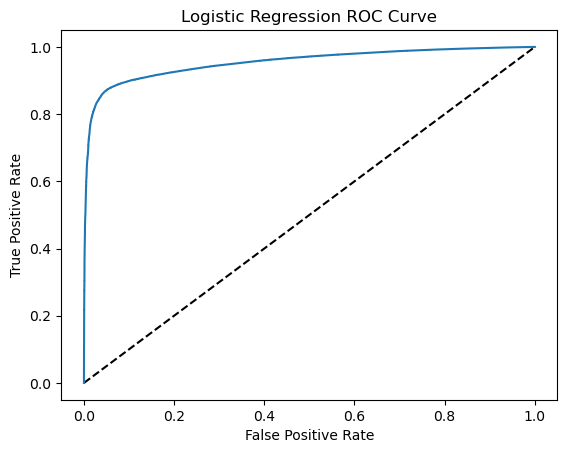

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

y_pred_probs = logreg.predict_proba(X_test)[:,1]
print(y_pred_probs[0:10])
print(roc_auc_score(y_test,y_pred_probs))

plot_roc_curve(y_test, y_pred_probs)

CONFUSION MATRIX & MODEL EVALUATION (chapter 4)